### Setting Up Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
county_data = pd.read_csv('us-counties.csv')
texas_data = county_data[(county_data['state'] == 'Texas')].copy(deep=True)

tx_dates = texas_data.groupby(by="date").sum().index.to_numpy()
tx_total_cases = texas_data.groupby(by="date").sum().cases.to_numpy()
tx_new_cases = np.zeros(tx_total_cases.shape)
for i in range(len(tx_total_cases)):
  if i == 0:
    tx_new_cases[i] = tx_total_cases[i]
  else:
    tx_new_cases[i] = tx_total_cases[i] - tx_total_cases[i-1]
tx_infected = np.zeros(tx_total_cases.shape)
tx_recovered = np.zeros(tx_total_cases.shape)
for i in range(len(tx_total_cases)):
  if i >= 13:
    recovered = sum(tx_new_cases[:i-13])
  else:
    recovered = 0
  tx_infected[i] = tx_total_cases[i] - recovered
  tx_recovered[i] = recovered

### Set Input Parameters

In [3]:
### Parameters to Vary ###

# lambda: number of people that a susceptible person interacts with per time step
# p: probability of getting infected if a susceptible person interacts with an infectious person
# gamma: recovery rate (recovery probability within one time step)
lam, p, gamma = 3, 0.05, 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

# probability of getting infected every time step
#beta = 1 - pow(1-p,lam)
beta = min(1, lam * p) # beta <= 1 by definition


In [12]:
### Fixed Parameters ###

# Total population. (Texas 2020)
N_total = 29145505

# Some vaccinated people are immune
N = N_total

# A grid of time points (in days) for the detecting period
t = np.linspace(0, len(tx_dates)-1, len(tx_dates))

# Initial number of infected and immune individuals, I0 and R0.
I0, R0 = 10, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

## Time Dependent  R_0

In [24]:
# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [25]:
def R_0_dynamic(t):
    value = None
    for i in range(len(epochs)):
        if t >= epochs[i]:
            value = logistic_R_0(t, k[i], x[i], R_0[i],  R_0[i+1])
    return value

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma

def logistic_R_0(t, k, x, start, end):
    return (start - end) / (1 + np.exp(-k * (-t + x))) + end

In [295]:
epochs = [0, 120, 210, 340, 400, 540, 660, 705]

R_0 = [2.0, 1.87, 0.7, 1.32, 0.6, 2.52, 0.8, 2.64, 0.04]

k = [0.3, 0.13, 0.2, 0.08, 0.08, 0.1, 0.1, 0.1]
x = [60, 150, 225, 341, 500, 550, 661, 710]

In [296]:
## NOTE: The R_0_dynamic is the time dependent *basic reproduction number*, 
## it is not the same as the R0 below, the *initial number of recovered people*.

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t, args=(N, beta_dynamic, gamma))
S, I, R = ret.T

/tmp/ipykernel_784/1009617507.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


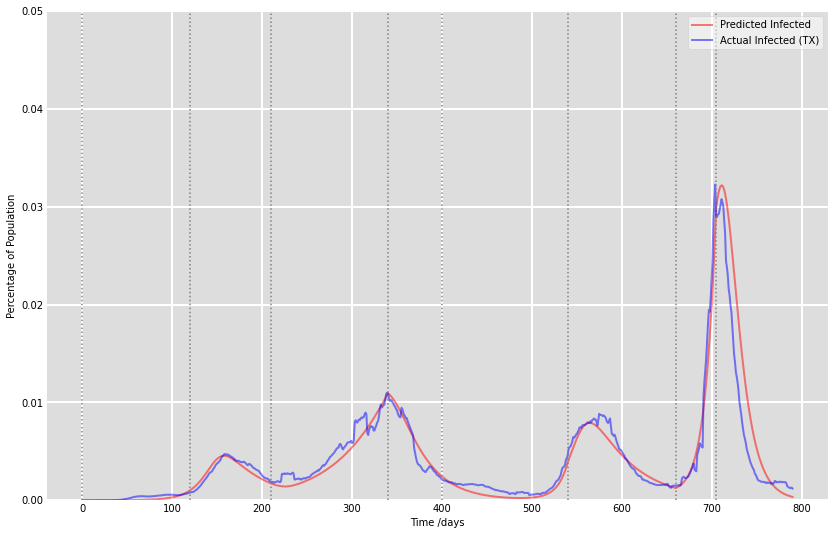

In [297]:
# Plot actual infect and predicted infected
fig = plt.figure(facecolor='w', figsize = (14, 9))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, I/N_total, 'r', alpha=0.5, lw=2, label='Predicted Infected')
ax.plot(t, tx_infected/N_total, 'b', alpha=0.5, lw=2, label='Actual Infected (TX)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,0.05)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

/tmp/ipykernel_784/4274951230.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


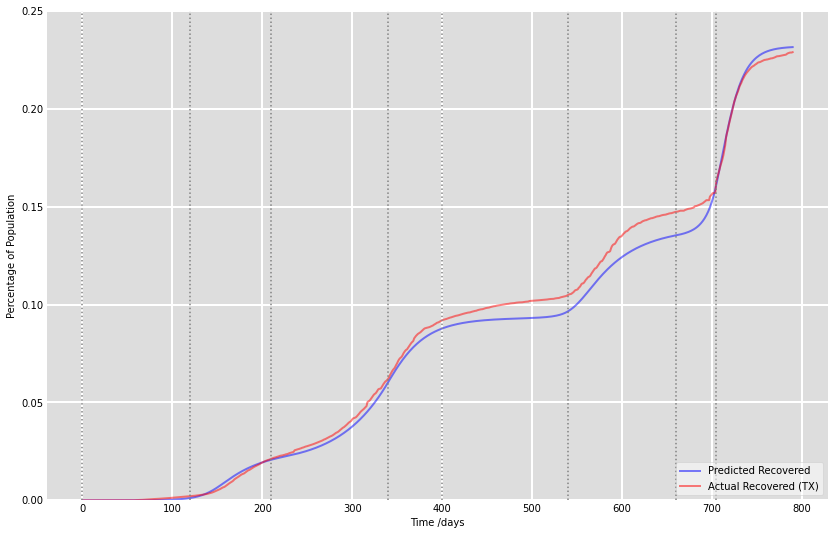

In [298]:
# Plot actual recovered and predicted recovered
fig = plt.figure(facecolor='w', figsize = (14, 9))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, R/N_total, 'b', alpha=0.5, lw=2, label='Predicted Recovered')
ax.plot(t, tx_recovered/N_total, 'r', alpha=0.5, lw=2, label='Actual Recovered (TX)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,0.25)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
for e in epochs:
    plt.axvline(x=e, color="grey", linestyle=':')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

### Calculate loss

In [299]:
import math

def abse(pred, true):
    sum = 0
    for i in range(len(true)):
       sum += abs(true[i] - pred[i]) 
    
    return sum / len(true)

def rmse(pred, true):
    sum = 0
    for i in range(len(true)):
        sum += math.pow(true[i] - pred[i], 2)
    
    return math.sqrt(sum / len(true))

print(f"Abolute Error: {abse(tx_infected,I/N_total)}")
print(f"RMSE: {rmse(tx_infected,I/N_total)}")

Abolute Error: 118481.41182997887
RMSE: 189892.77473200051
